# Citibike Proprocessing

In [ ]:
import numpy as np
import pandas as pd
import pickle
import random
from datetime import datetime
import datetime as dt
from collections import Counter
import sys
import importlib

import dask
import dask.dataframe as dd
from dask.distributed import Client, progress

from helper_functions import read_data_dask, count_missing_date

In [2]:
client = Client(n_workers=4, threads_per_worker=2)
client

Client Scheduler: tcp://127.0.0.1:41255 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 31.63 GB


In [45]:
# files to read in based on month-year from: https://s3.amazonaws.com/tripdata/index.html
months = [201501, 201502, 201503, 201504, 201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512, 
          201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608, 201609, 201610, 201611, 201612, 
          201701, 201702, 201703, 201704, 201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712, 
          201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808, 201809, 201810, 201811, 201812,
          201901, 201902, 201903, 201904, 201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912]

In [46]:
citibike_transactions = read_data_dask(months)

/home/jlee_sbu/anaconda3/envs/metis/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34211 instead
  http_address["port"], self.http_server.port
/home/jlee_sbu/anaconda3/envs/metis/lib/python3.7/site-packages/dask/dataframe/io/csv.py:387: UserWarning: Warning zip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression
/home/jlee_sbu/anaconda3/envs/metis/lib/python3.7/site-packages/dask/dataframe/io/csv.py:387: UserWarning: Warning zip compression does not support breaking apart files
Please ensure that each individual file can fit in memory and
use the keyword ``blocksize=None to remove this message``
Setting ``blocksize=None``
  "Setting ``blocksize=None``" % compression


In [36]:
# number of total citibike rides
len(citibike_transactions)

78248317

In [ ]:
# store dataframe in parquet
citibike_transactions.to_parquet('citibike_transactions.parquet', engine='fastparquet')

In [5]:
!ls

201902-citibike-tripdata.csv	    citibike_transactions.csv
aisles.csv			    citibike_transactions.parquet
anaconda3			    daily_df.pkl
Anaconda3-2020.02-Linux-x86_64.sh   dask-worker-space
citibike_201901.csv		    derby.log
citibike_201902.csv		    instacart_feature_engineering.ipynb
citibike_data			    metastore_db
citibike_preprocessing.ipynb	    Music
citibike_preprocessing.py	    __pycache__
citibike_preprocessing-SPARK.ipynb  spark-2.3.1-bin-hadoop2.7
citibikes_df.pkl		    spark-2.3.1-bin-hadoop2.7.tar


In [19]:
# data types of columns
citibike_transactions.dtypes

tripduration                      float64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bikeid                            float64
usertype                           object
birth_year                        float64
gender                            float64
dtype: object

In [37]:
# head of dataframe
citibike_transactions.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1346.0,1/1/2015 0:01,1/1/2015 0:24,455.0,1 Ave & E 44 St,40.750020,-73.969053,265.0,Stanton St & Chrystie St,40.722293,-73.991475,18660.0,Subscriber,1960.0,2.0
1,363.0,1/1/2015 0:02,1/1/2015 0:08,434.0,9 Ave & W 18 St,40.743174,-74.003664,482.0,W 15 St & 7 Ave,40.739355,-73.999318,16085.0,Subscriber,1963.0,1.0
2,346.0,1/1/2015 0:04,1/1/2015 0:10,491.0,E 24 St & Park Ave S,40.740964,-73.986022,505.0,6 Ave & W 33 St,40.749013,-73.988484,20845.0,Subscriber,1974.0,1.0
3,182.0,1/1/2015 0:04,1/1/2015 0:07,384.0,Fulton St & Waverly Ave,40.683178,-73.965964,399.0,Lafayette Ave & St James Pl,40.688515,-73.964763,19610.0,Subscriber,1969.0,1.0
4,969.0,1/1/2015 0:05,1/1/2015 0:21,474.0,5 Ave & E 29 St,40.745168,-73.986831,432.0,E 7 St & Avenue A,40.726218,-73.983799,20197.0,Subscriber,1977.0,1.0


In [38]:
citibike_transactions.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 15 entries, tripduration to gender
dtypes: object(5), float64(10)

## Data Cleaning

In [47]:
# clean column names
citibike_transactions.columns = citibike_transactions.columns.str.replace(' ', '_')
citibike_transactions.columns = citibike_transactions.columns.str.lower()
citibike_transactions.columns

Index(['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_latitude',
       'start_station_longitude', 'end_station_id', 'end_station_name',
       'end_station_latitude', 'end_station_longitude', 'bikeid', 'usertype',
       'birth_year', 'gender'],
      dtype='object')

In [9]:
# missing values per column
citibike_transactions.isna().sum().compute()

tripduration                     0
starttime                        0
stoptime                         0
start_station_id              2677
start_station_name            2677
start_station_latitude           0
start_station_longitude          0
end_station_id                2677
end_station_name              2677
end_station_latitude             0
end_station_longitude            0
bikeid                           0
usertype                     51780
birth_year                 4528576
gender                           0
dtype: int64

In [48]:
# remove rows with missing start station values
citibike_transactions = citibike_transactions.dropna(subset = ['start_station_id'])

In [20]:
len(citibike_transactions)

78245640

In [21]:
citibike_transactions.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,1346.0,1/1/2015 0:01,1/1/2015 0:24,455.0,1 Ave & E 44 St,40.750020,-73.969053,265.0,Stanton St & Chrystie St,40.722293,-73.991475,18660.0,Subscriber,1960.0,2.0
1,363.0,1/1/2015 0:02,1/1/2015 0:08,434.0,9 Ave & W 18 St,40.743174,-74.003664,482.0,W 15 St & 7 Ave,40.739355,-73.999318,16085.0,Subscriber,1963.0,1.0
2,346.0,1/1/2015 0:04,1/1/2015 0:10,491.0,E 24 St & Park Ave S,40.740964,-73.986022,505.0,6 Ave & W 33 St,40.749013,-73.988484,20845.0,Subscriber,1974.0,1.0
3,182.0,1/1/2015 0:04,1/1/2015 0:07,384.0,Fulton St & Waverly Ave,40.683178,-73.965964,399.0,Lafayette Ave & St James Pl,40.688515,-73.964763,19610.0,Subscriber,1969.0,1.0
4,969.0,1/1/2015 0:05,1/1/2015 0:21,474.0,5 Ave & E 29 St,40.745168,-73.986831,432.0,E 7 St & Avenue A,40.726218,-73.983799,20197.0,Subscriber,1977.0,1.0


In [42]:
citibike_transactions.dtypes

tripduration                      float64
starttime                  datetime64[ns]
stoptime                   datetime64[ns]
start_station_id                  float64
start_station_name                 object
start_station_latitude            float64
start_station_longitude           float64
end_station_id                    float64
end_station_name                   object
end_station_latitude              float64
end_station_longitude             float64
bikeid                            float64
usertype                           object
birth_year                        float64
gender                            float64
dtype: object

In [3]:
# store dataframe in parquet
#citibike_transactions.to_parquet('citibike_transactions.parquet', engine='fastparquet')
citibike_transactions = dd.read_parquet('/home/jlee_sbu/citibike_transactions.parquet', engine='fastparquet') 

## Aggregate data into daily ride counts per station

In [49]:
# aggregate data by date into pandas dataframe
citibike_df = citibike_transactions.groupby([citibike_transactions.starttime.dt.date, 
                                     citibike_transactions.start_station_id, 
                                     citibike_transactions.start_station_name]).agg(
                                            {'start_station_latitude':'mean', 
                                             'start_station_longitude':'mean',
                                             'tripduration':'mean', 
                                             'start_station_id':'size'}).rename(
                                            columns={'start_station_latitude':'start_station_latitude', 
                                                     'start_station_longitude':'start_station_longitude', 
                                                     'tripduration':'mean_duration', 
                                                     'start_station_id':'ride_counts'}).reset_index().compute()

citibike_df.columns = ['date', 'station_id', 'station_name', 'station_latitude', 
                       'station_longitude', 'mean_duration', 'ride_counts']

citibike_df.date = pd.to_datetime(citibike_df.date)
citibike_df.station_id = citibike_df.station_id.astype(int)

In [509]:
# head of dataframe
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,ride_counts
0,2015-01-01,72,W 52 St & 11 Ave,40.767272,-73.993929,1062.700000,10
1,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,15
2,2015-01-01,82,St James Pl & Pearl St,40.711174,-74.000165,535.000000,10
3,2015-01-01,83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323,475.000000,7
4,2015-01-01,116,W 17 St & 8 Ave,40.741776,-74.001497,773.357143,28


In [510]:
# datatypes of dataframe columns
citibike_df.dtypes

date                 datetime64[ns]
station_id                    int64
station_name                 object
station_latitude            float64
station_longitude           float64
mean_duration               float64
ride_counts                   int64
dtype: object

In [50]:
# shape of dataframe
citibike_df.shape

(1104197, 7)

In [82]:
# pickle dataframe
#citibike_df.to_pickle('data/citibike_df_raw.pkl')
citibike_df = pd.read_pickle('data/citibike_df_raw.pkl')

In [5]:
# number of unique stations
len(citibike_df.station_id.unique())

1064

In [515]:
# number of unique dates present in data
len(citibike_df.date.unique())

1818

In [518]:
# total number of calendar days from 1-1-2015 to 12-31-2019
5*365+1 # add one day for leap year in 2016

1826

In [102]:
# reload updated module
importlib.reload(sys.modules['helper_functions'])
from citibike_preprocessing import count_missing_dates

In [103]:
# top 10 stations with the most missing dates
station_missing_dates, station_missing_dates_sorted = count_missing_dates(citibike_df) 
print("Top 10 stations with the highest # of missing dates:")
for r in station_missing_dates_sorted[0:10]:
    print("station id", r, ": ", station_missing_dates[r])

Top 10 stations with the highest # of missing dates:
station id 3252 :  1825
station id 3385 :  1825
station id 3446 :  1825
station id 3248 :  1825
station id 3633 :  1825
station id 3685 :  1825
station id 3253 :  1824
station id 3257 :  1824
station id 3266 :  1824
station id 3197 :  1824


In [104]:
# number of stations in existence in January of 2015-2019
cutoffs = ['2015-02-01', '2016-02-01', '2017-02-01', '2018-02-01', '2019-02-01']
print("# of stations in existence before date: ")
for cutoff in cutoffs:
    print(cutoff, ": " , len(citibike_df[citibike_df.date < cutoff].station_id.unique()))

# of stations in existence before date: 
2015-02-01 :  330
2016-02-01 :  490
2017-02-01 :  665
2018-02-01 :  864
2019-02-01 :  913


In [105]:
# number of stations that existed since January 2015 and still exist in December 2019
stations_jan2015 = citibike_df[citibike_df.date < '2015-02-01'].station_id.unique()
stations_dec2019 = citibike_df[citibike_df.date > '2019-11-30'].station_id.unique()
stations = np.intersect1d(stations_jan2015, stations_dec2019)
len(stations)

271

In [106]:
# filter dataframe down to the stations that existed since January 2015
citibike_df = citibike_df[citibike_df.station_id.isin(stations)]

In [107]:
# top 10 stations with the most missing dates
station_missing_dates, station_missing_dates_sorted = count_missing_dates(citibike_df) 
print("Top 10 stations with the highest # of missing dates:")
for r in station_missing_dates_sorted[0:10]:
    print("station id", r, ": ", station_missing_dates[r])

Top 10 stations with the highest # of missing dates:
station id 464 :  1464
station id 489 :  1161
station id 250 :  1135
station id 367 :  1024
station id 2017 :  735
station id 493 :  681
station id 224 :  622
station id 434 :  618
station id 116 :  599
station id 298 :  518


In [108]:
# number of stations to use 
stations = station_missing_dates_sorted[11:]
len(stations)

260

In [109]:
# filter dataframe down to the stations that existed since January 2015
citibike_df = citibike_df[citibike_df.station_id.isin(stations)]

In [110]:
# top 10 stations with the most missing dates
station_missing_dates, station_missing_dates_sorted = count_missing_dates(citibike_df) 
print("Top 10 stations with the highest # of missing dates:")
for r in station_missing_dates_sorted[0:10]:
    print("station id", r, ": ", station_missing_dates[r])

Top 10 stations with the highest # of missing dates:
station id 403 :  397
station id 284 :  391
station id 223 :  326
station id 385 :  290
station id 439 :  214
station id 540 :  209
station id 316 :  183
station id 533 :  179
station id 405 :  164
station id 2003 :  157


In [133]:
# station with the most missing dates, by year and month
station = station_missing_dates_sorted[1]
print("Number of dates for station id", station, ":")
for i in range(2015, 2020):
    print("year", i, ": ", len(citibike_df[(citibike_df.station_id == station) & 
                                           (citibike_df.date.dt.year == i)].date))
    
print("Number of dates for station id", station, ":")
for i in range(1, 13):
    print("month", i, ": ", len(citibike_df[(citibike_df.station_id == station) & 
                                            (citibike_df.date.dt.month == i)].date))    

Number of dates for station id 284 :
year 2015 :  365
year 2016 :  362
year 2017 :  360
year 2018 :  102
year 2019 :  246
Number of dates for station id 284 :
month 1 :  120
month 2 :  112
month 3 :  120
month 4 :  103
month 5 :  124
month 6 :  120
month 7 :  124
month 8 :  124
month 9 :  120
month 10 :  124
month 11 :  120
month 12 :  124


For station 284, there is no data for most of 2018

In [313]:
# station with the most missing dates
station = station_missing_dates_sorted[1]
print("Number of dates for station id", station, ":")
for i in range(2015, 2020):
    for j in range(1, 13):
        print("year", i, "month", j, ": ", len(citibike_df[(citibike_df.station_id == station) & 
                                                           (citibike_df.date.dt.year == i) & 
                                                           (citibike_df.date.dt.month == j)].date))

Number of dates station 284 :
year 2015 month 1 :  31
year 2015 month 2 :  28
year 2015 month 3 :  31
year 2015 month 4 :  30
year 2015 month 5 :  31
year 2015 month 6 :  30
year 2015 month 7 :  31
year 2015 month 8 :  31
year 2015 month 9 :  30
year 2015 month 10 :  31
year 2015 month 11 :  30
year 2015 month 12 :  31
year 2016 month 1 :  27
year 2016 month 2 :  29
year 2016 month 3 :  31
year 2016 month 4 :  30
year 2016 month 5 :  31
year 2016 month 6 :  30
year 2016 month 7 :  31
year 2016 month 8 :  31
year 2016 month 9 :  30
year 2016 month 10 :  31
year 2016 month 11 :  30
year 2016 month 12 :  31
year 2017 month 1 :  31
year 2017 month 2 :  27
year 2017 month 3 :  27
year 2017 month 4 :  30
year 2017 month 5 :  31
year 2017 month 6 :  30
year 2017 month 7 :  31
year 2017 month 8 :  31
year 2017 month 9 :  30
year 2017 month 10 :  31
year 2017 month 11 :  30
year 2017 month 12 :  31
year 2018 month 1 :  31
year 2018 month 2 :  28
year 2018 month 3 :  31
year 2018 month 4 :  12
y

In [134]:
# add in missing dates for each station with ride counts as zero
citibike_df = citibike_df.reset_index(drop=True)
citibike_df = citibike_df.set_index(['date', 'station_id']).unstack(
    fill_value=0).asfreq('D', fill_value=0).stack().sort_index(level=1).reset_index()

In [142]:
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,ride_counts
0,2015-01-01,72,W 52 St & 11 Ave,40.767272,-73.993929,1062.700000,10
1,2015-01-02,72,W 52 St & 11 Ave,40.767272,-73.993929,578.222222,27
2,2015-01-03,72,W 52 St & 11 Ave,40.767272,-73.993929,838.307692,13
3,2015-01-04,72,W 52 St & 11 Ave,40.767272,-73.993929,1051.423077,26
4,2015-01-05,72,W 52 St & 11 Ave,40.767272,-73.993929,705.187500,32


In [139]:
citibike_df[citibike_df.ride_counts == 0]

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,ride_counts
387,2016-01-23,72,0,0.0,0.0,0.0,0
388,2016-01-24,72,0,0.0,0.0,0.0,0
389,2016-01-25,72,0,0.0,0.0,0.0,0
390,2016-01-26,72,0,0.0,0.0,0.0,0
770,2017-02-09,72,0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...
473324,2016-01-26,3002,0,0.0,0.0,0.0,0
473704,2017-02-09,3002,0,0.0,0.0,0.0,0
473737,2017-03-14,3002,0,0.0,0.0,0.0,0
473738,2017-03-15,3002,0,0.0,0.0,0.0,0


In [137]:
citibike_df.shape

(474760, 7)

In [144]:
# pickle dataframe
#citibike_df.to_pickle('data/citibike_df.pkl')
citibike_df = pd.read_pickle('data/citibike_df.pkl')

## Aggregate ride counts for each station by year-month

In [13]:
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,ride_counts
0,2015-01-01,72,W 52 St & 11 Ave,40.767272,-73.993929,1062.700000,10
1,2015-01-02,72,W 52 St & 11 Ave,40.767272,-73.993929,578.222222,27
2,2015-01-03,72,W 52 St & 11 Ave,40.767272,-73.993929,838.307692,13
3,2015-01-04,72,W 52 St & 11 Ave,40.767272,-73.993929,1051.423077,26
4,2015-01-05,72,W 52 St & 11 Ave,40.767272,-73.993929,705.187500,32


In [156]:
# aggregate number of missing dates for every month-year by station
citibike_grouped = citibike_df[citibike_df.ride_counts == 0].groupby(
    [citibike_df.station_id, citibike_df.date.dt.year, citibike_df.date.dt.month]).date.agg(
    count_missing_dates=('date', 'nunique'))

citibike_grouped.index.names = ['station_id', 'year', 'month']
citibike_grouped = citibike_grouped.reset_index()

citibike_grouped.head()

,station_id,year,month,count_missing_dates
0,72,2016,1,4
1,72,2017,2,2
2,72,2017,3,4
3,72,2019,10,10
4,72,2019,11,3


In [158]:
# number of months where month is missing 10 or more days
stations_missing_majority_months = \
    citibike_grouped[citibike_grouped.count_missing_dates > 10].groupby(['station_id']).agg(
    {'count_missing_dates':'size'}).sort_values(
    'count_missing_dates', ascending=False).rename(
    columns={'count_missing_dates':'months_missing_more_than_ten_dates'}).reset_index()

stations_missing_majority_months

,station_id,months_missing_more_than_ten_dates
0,403,13
1,284,13
2,223,11
3,385,9
4,439,8
...,...,...
109,334,1
110,328,1
111,325,1
112,394,1


In [164]:
# stations with more than 1 month where month is missing 10 or more days
exclude_stations = stations_missing_majority_months[stations_missing_majority_months.
                                                    months_missing_more_than_ten_dates > 1].station_id

# exclude those stations
citibike_grouped = citibike_grouped[~citibike_grouped.station_id.isin(exclude_stations)]
citibike_df = citibike_df[~citibike_df.station_id.isin(exclude_stations)]

In [101]:
# stations with missing dates in Nov and Dec 2019 (validation and test sets)
citibike_grouped[(citibike_grouped.year == 2019) & 
                 (citibike_grouped.month.isin([11, 12]))].station_id

4         72
141      173
372      274
646      337
1060     421
1144     443
1261     467
1285     469
1331     477
1404     490
1424     495
1425     495
1448     500
1665     539
1705    2002
1725    2006
Name: station_id, dtype: int64

In [171]:
# exclude the stations with missing dates in the last month of the dataset (test set)
exclude_stations = citibike_grouped[(citibike_grouped.year==2019) & 
                                    (citibike_grouped.month.isin([11, 12]))].station_id
citibike_grouped = citibike_grouped[~citibike_grouped.station_id.isin(exclude_stations)]
citibike_df = citibike_df[~citibike_df.station_id.isin(exclude_stations)]

In [172]:
# number of stations to move forward with
len(citibike_df.station_id.unique())

182

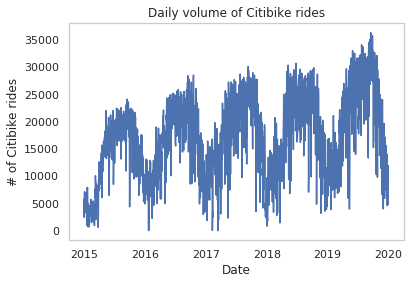

In [108]:
# plot daily ride counts across all stations, to help decide on imputation method
plt.plot(citibike_df.groupby(['date']).agg({'ride_counts':'sum'}))
plt.title('Daily volume of Citibike rides')
plt.xlabel('Date')
plt.ylabel('# of Citibike rides');

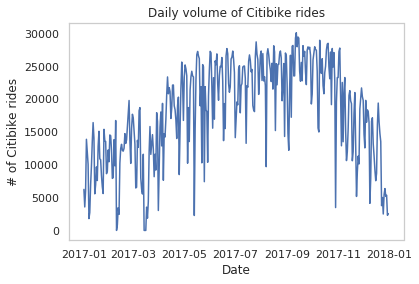

In [109]:
# plot daily ride counts across all stations for a particular year, to help decide on imputation method
plt.plot(citibike_df[citibike_df.date.dt.year == 2017].groupby(['date']).agg({'ride_counts':'sum'}))
plt.title('Daily volume of Citibike rides')
plt.xlabel('Date')
plt.ylabel('# of Citibike rides');

## Impute missing values

In [152]:
# create year and month columns
citibike_df.loc[:, 'year'] = citibike_df.date.dt.year
citibike_df.loc[:, 'month'] = citibike_df.date.dt.month

# reorder columns
citibike_df = citibike_df[['date', 'station_id', 'station_name', 'station_latitude', 'station_longitude',
                           'mean_duration', 'year', 'month', 'ride_counts']]

citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,ride_counts
1826,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,15
1827,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,22
1828,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,15
1829,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,27
1830,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,27


In [153]:
# add new counts column that replace zero ride counts with rolling 90-day median value per station
citibike_df['replace_zeroes'] = \
    citibike_df.groupby('station_id')['ride_counts'].rolling(
    window=90, min_periods=1).median().shift(1).apply(np.floor).reset_index(0, drop=True)

citibike_df['ride_counts_clean'] = citibike_df.ride_counts
citibike_df.loc[citibike_df.ride_counts != 0, ['replace_zeroes']] = np.nan
citibike_df.loc[citibike_df.ride_counts == 0, ['ride_counts_clean']] = citibike_df.replace_zeroes

# convert ride counts imputed to int datatype
citibike_df.ride_counts_clean = citibike_df.ride_counts_clean.astype(int) 

In [154]:
# new shape
citibike_df.shape

(332332, 11)

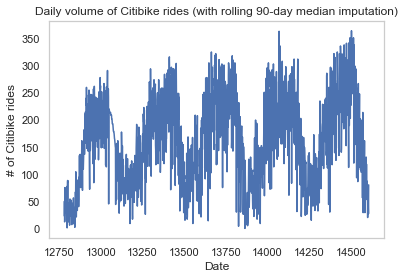

In [178]:
# plot imputed daily ride counts for a specific station
plt.plot(citibike_df[citibike_df.station_id == 128].ride_counts_clean)
plt.title('Daily volume of Citibike rides (with rolling 90-day median imputation)')
plt.xlabel('Date')
plt.ylabel('# of Citibike rides');

In [180]:
# confirm that there are no missing dates after imputation
pd.date_range(start = '2015-01-01', end = '2019-12-31').difference(citibike_df.date)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

## Additional columns and cleanup

In [181]:
# add day of week in dataframe
citibike_df['day_of_week'] = citibike_df.date.dt.weekday

In [183]:
# add station info
station_info = citibike_df[(citibike_df.station_name != 0) & 
                           (citibike_df.station_latitude != 0) &
                           (citibike_df.station_longitude != 0)].groupby(['station_id', 'station_name', 'station_latitude', 'station_longitude']).size().reset_index().rename(columns={0:'count'}).drop('count', axis=1)

# drop duplicates
station_info.drop_duplicates(subset=['station_id'], inplace=True)
station_info.head()

,station_id,station_name,station_latitude,station_longitude
0,79,Franklin St & W Broadway,40.719116,-74.006667
57,119,Park Ave & St Edwards St,40.696089,-73.978034
61,120,Lexington Ave & Classon Ave,40.686768,-73.959282
80,127,Barrow St & Hudson St,40.731724,-74.006744
133,128,MacDougal St & Prince St,40.727103,-74.002971


In [89]:
# merge with citibike df
citibike_df = citibike_df.merge(station_info, how='left', left_on='station_id', right_on='station_id')

# drop columns
citibike_df = citibike_df.drop(['station_name_x', 'station_latitude_x', 'station_longitude_x'], axis=1)

# rename columns
citibike_df.columns = ['date', 'station_id', 'mean_duration', 'year', 'month', 'ride_counts',
                         'replace_zeroes', 'ride_counts_clean', 'day_of_week', 
                         'station_name', 'station_latitude', 'station_longitude']
# reorder columns
citibike_df = citibike_df[['date', 'station_id', 'station_name', 'station_latitude', 'station_longitude',
                           'mean_duration', 'year', 'month', 'day_of_week',
                           'ride_counts','replace_zeroes', 'ride_counts_clean']]

# drop some columns and reset index
citibike_df = citibike_df.reset_index(drop=True)

In [90]:
citibike_df.shape

(332332, 12)

In [91]:
citibike_df.head()

,date,station_id,station_name,station_latitude,station_longitude,mean_duration,year,month,day_of_week,ride_counts,replace_zeroes,ride_counts_clean
0,2015-01-01,79,Franklin St & W Broadway,40.719116,-74.006667,880.133333,2015,1,3,15,NaN,15
1,2015-01-02,79,Franklin St & W Broadway,40.719116,-74.006667,1499.818182,2015,1,4,22,NaN,22
2,2015-01-03,79,Franklin St & W Broadway,40.719116,-74.006667,432.266667,2015,1,5,15,NaN,15
3,2015-01-04,79,Franklin St & W Broadway,40.719116,-74.006667,693.666667,2015,1,6,27,NaN,27
4,2015-01-05,79,Franklin St & W Broadway,40.719116,-74.006667,669.000000,2015,1,0,27,NaN,27


In [93]:
# pickle dataframe
#citibike_df.to_pickle('data/citibike_df_preprocessed.pkl')
citibike_df = pd.read_pickle('data/citibike_df_preprocessed.pkl')